In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd "/content/drive/MyDrive/project/submission folder/"
!ls

/content/drive/.shortcut-targets-by-id/12bQn6IHlaXgvQmuiFGjGLbNC0j_L-m2j/project/submission folder
'Copy of CSE_354_Project_classification.ipynb'	 Distilbert_classification
'Copy of CSE 354 Project_regression.ipynb'	 Distilbert_regression
'CSE354_Report_Amazon Rate Predictor.pdf'	'io test.ipynb'


In [ ]:
!pip install datasets
!pip install transformers

import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
from tqdm import tqdm
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import AdamW
import os
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score # classification metrics
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score # regression metrics
from datasets import load_dataset
import matplotlib.pyplot as plt
import random
torch.manual_seed(42)
np.random.seed(42)

In [ ]:
test_data  = load_dataset("amazon_reviews_multi", "en", split='test')

In [ ]:
class Distilbert():

  def __init__(self, model_path):
    self.model = AutoModelForSequenceClassification.from_pretrained(model_path)
    self.tokenizer = AutoTokenizer.from_pretrained(model_path)

  def get_tokenizer_and_model(self):
    return self.model, self.tokenizer

In [ ]:
def review(task, review):
  model_path = "Distilbert_" + task
  transformer = Distilbert(model_path)
  model, tokenizer = transformer.get_tokenizer_and_model()
  review_encoding = tokenizer.encode_plus(review, truncation=True, max_length = 512)["input_ids"]
  review_encoding = torch.tensor([review_encoding]).to("cpu")
  output = model(review_encoding)["logits"] # +1 since it's 0-4 and we want 1-5
  if task == 'regression':
    stars = int(torch.round(output[0]*5))
  else:
    stars = torch.argmax(output) + 1
  print("★"*stars + "☆"*(5-stars))
  # print(int(stars), "stars")

In [ ]:
#@markdown Choose the problem type (classification or regression), input a review, and run!
task = "classification" #@param ["classification", "regression"]
text = "This thermometer leaves way too much room for improvement. Both magnets came off of the unit and stuck to my grill on only it's second use. The leads on the two probes are much too short to use practically when cooking in my oven. There's a standard meat/taste probe but limited options on taste for each meat would leave my chicken and pork dishes overcooked . . .and those are the primary reason I purchase a meat thermometer! I can only use probe 2 to manually set temperature, and it's not easy to do at that. And multiple times, I've had to turn the unit back on because it went to \"sleep\" while I was cooking! I terribly miss my remote unit for barbecuing outdoors, and the tiny hand in front of a huge thermometer? Well, I should've known it couldn't be that big. I would not recommend this thermometer...too many negatives. Shop for something else." #@param {type:"string"}
review(task, text)

★★☆☆☆


In [ ]:
#@markdown Choose the problem type (classification or regression), input a review, and run!
task = "regression" #@param ["classification", "regression"]
text = "this is the best product I have ever bought. Well worth the money. I loved using this product. It will last you forever. Buy this product!" #@param {type:"string"}
review(task, text)

★★★★★


In [ ]:

def test(task):
  model_path = "Distilbert_" + task
  transformer = Distilbert(model_path)
  model, tokenizer = transformer.get_tokenizer_and_model()
  

  preds = []
  labels = []
  
  review_list = test_data['review_body']
  title_list = test_data['review_title']
  label_list = test_data['stars']
  data = list(zip(review_list, label_list, title_list))
  random.shuffle(data)
  num_training = 400
  data = data[:num_training]
  for review, label, title in tqdm(data, total=len(data)):
    review_encoding = tokenizer.encode_plus(review, truncation=True, max_length = 512)
    review_encoding = review_encoding['input_ids']
    review_encoding = torch.tensor([review_encoding]).to("cpu")
    output = model(review_encoding.cpu())["logits"] # +1 since it's 0-4 and we want 1-5
    if task == 'regression':
      stars = int(torch.round(output[0]*5))
    else:
      stars = int(torch.argmax(output, axis=1) + 1)
    preds.append(stars)
    labels.append(np.float32(label))
  ConfusionMatrixDisplay.from_predictions(labels, preds)
  plt.show

  


100%|██████████| 400/400 [00:33<00:00, 11.94it/s]


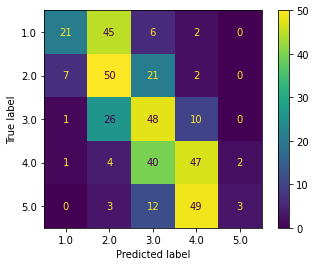

In [ ]:
test('regression')

100%|██████████| 400/400 [00:33<00:00, 12.00it/s]


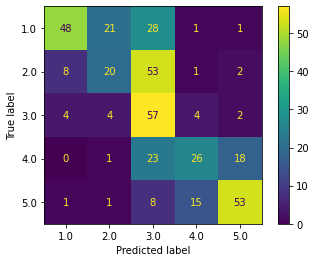

In [ ]:
test('classification')